In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


In [2]:

df = pd.read_csv('HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [4]:
df.shape

(10015, 7)

In [5]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = r'C:\Users\keyap\Desktop\skin cancer'

In [6]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [7]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,C:\Users\keyap\Desktop\skin cancer\HAM10000_im...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,C:\Users\keyap\Desktop\skin cancer\HAM10000_im...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,C:\Users\keyap\Desktop\skin cancer\HAM10000_im...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,C:\Users\keyap\Desktop\skin cancer\HAM10000_im...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,C:\Users\keyap\Desktop\skin cancer\HAM10000_im...,Benign keratosis-like lesions,2


In [8]:
df.isna().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [9]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [10]:
df.isna().sum().sum()

0

C:\Users\keyap\AppData\Local\Temp\ipykernel_51864\1507812108.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex',data=df, palette = 'Paired')


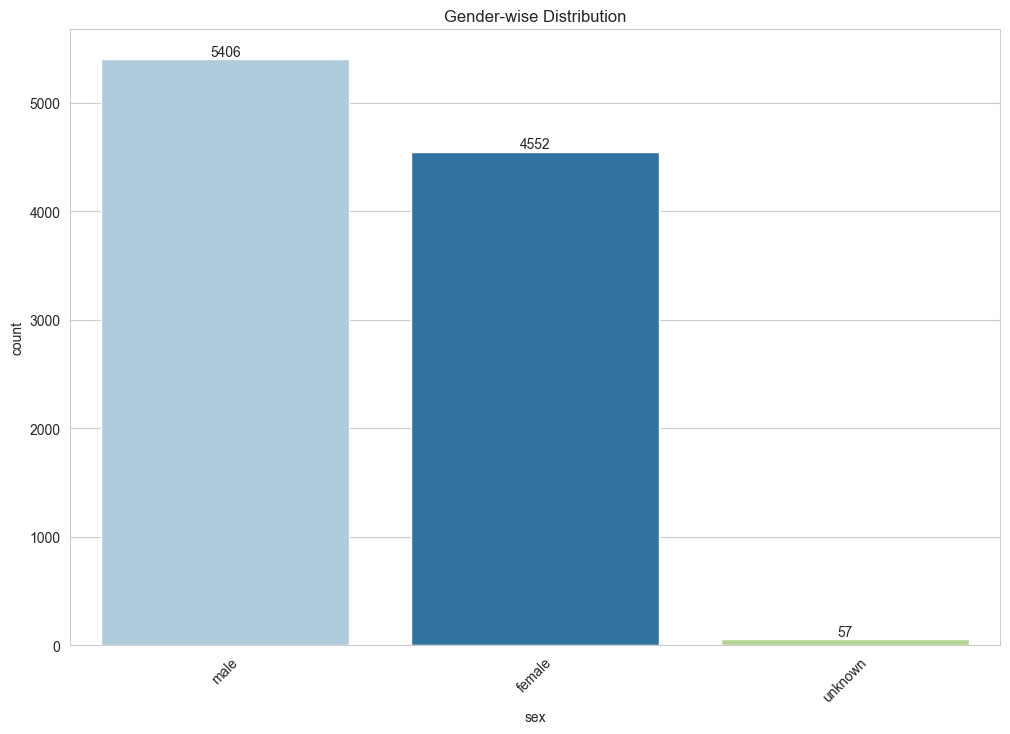

In [41]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='sex',data=df, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.savefig('gender_distribution_plot.svg', format='svg')
plt.show()

C:\Users\keyap\AppData\Local\Temp\ipykernel_51864\2077800454.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')


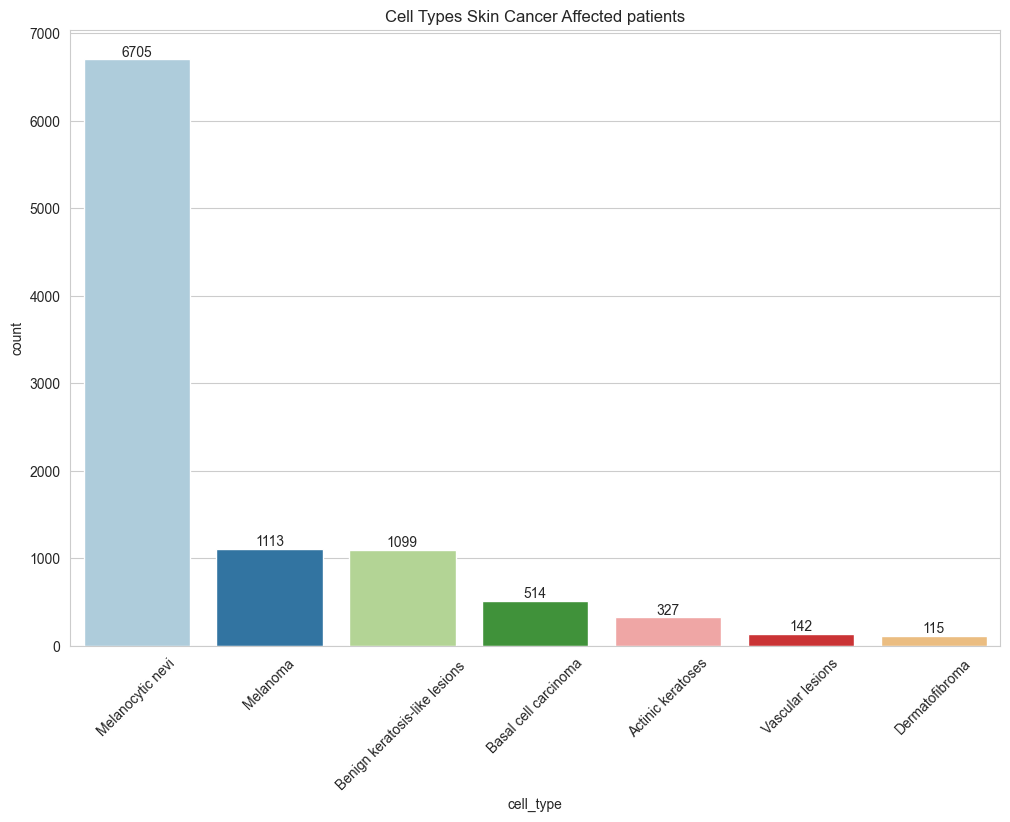

In [42]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='cell_type',data=df, order = df['cell_type'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Skin Cancer Affected patients')
plt.xticks(rotation=45)
plt.savefig('count_plot.svg', format='svg')
plt.show()

In [13]:
df['path'].head()

0    C:\Users\keyap\Desktop\skin cancer\HAM10000_im...
1    C:\Users\keyap\Desktop\skin cancer\HAM10000_im...
2    C:\Users\keyap\Desktop\skin cancer\HAM10000_im...
3    C:\Users\keyap\Desktop\skin cancer\HAM10000_im...
4    C:\Users\keyap\Desktop\skin cancer\HAM10000_im...
Name: path, dtype: object

In [14]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

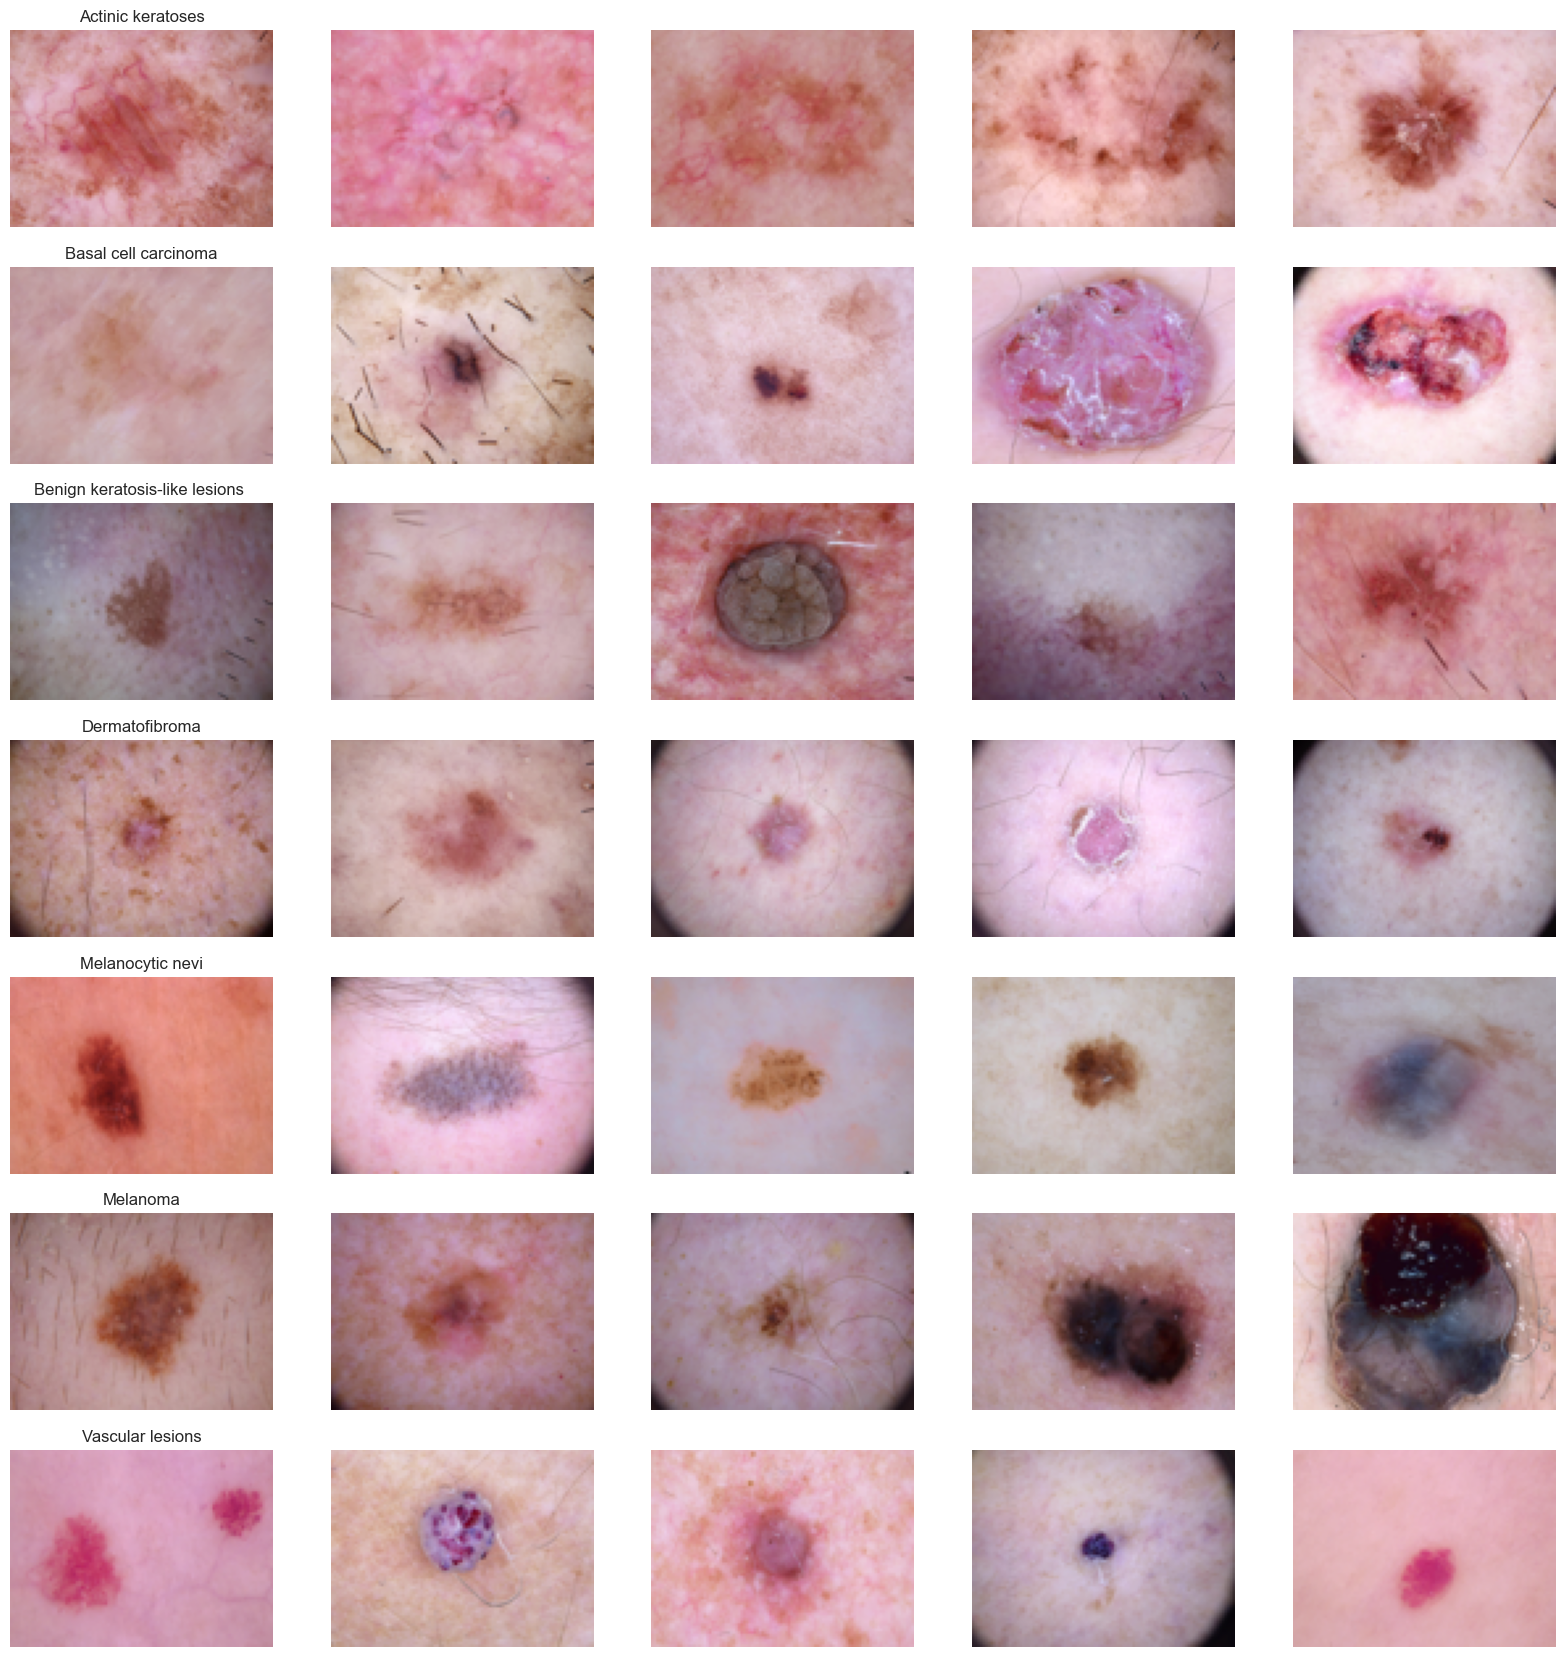

In [15]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [16]:
df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    10015
Name: count, dtype: int64

In [17]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [18]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [19]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [20]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [21]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [22]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [23]:
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                      

In [24]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

# Define the optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)


In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [28]:
epochs = 50
batch_size = 10

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_validate, y_validate),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[learning_rate_reduction]
)


Epoch 1/50
721/721 [==============================] - 83s 111ms/step - loss: 1.0351 - accuracy: 0.6652 - val_loss: 0.9110 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 2/50
721/721 [==============================] - 80s 111ms/step - loss: 0.9271 - accuracy: 0.6718 - val_loss: 0.9035 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 3/50
721/721 [==============================] - 80s 111ms/step - loss: 0.8904 - accuracy: 0.6764 - val_loss: 0.8394 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 4/50
721/721 [==============================] - 80s 111ms/step - loss: 0.8584 - accuracy: 0.6889 - val_loss: 0.7892 - val_accuracy: 0.7095 - lr: 0.0010
Epoch 5/50
721/721 [==============================] - 80s 111ms/step - loss: 0.8220 - accuracy: 0.6994 - val_loss: 0.8499 - val_accuracy: 0.6983 - lr: 0.0010
Epoch 6/50
721/721 [==============================] - 80s 111ms/step - loss: 0.8086 - accuracy: 0.7093 - val_loss: 0.7658 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 7/50
721/721 [==============================] 

Epoch 45/50
721/721 [==============================] - 83s 115ms/step - loss: 0.5530 - accuracy: 0.7928 - val_loss: 0.6076 - val_accuracy: 0.7855 - lr: 1.0000e-05
Epoch 46/50
721/721 [==============================] - 80s 111ms/step - loss: 0.5540 - accuracy: 0.7932 - val_loss: 0.6062 - val_accuracy: 0.7868 - lr: 1.0000e-05
Epoch 47/50
721/721 [==============================] - 79s 110ms/step - loss: 0.5556 - accuracy: 0.7903 - val_loss: 0.6142 - val_accuracy: 0.7868 - lr: 1.0000e-05
Epoch 48/50
721/721 [==============================] - 79s 110ms/step - loss: 0.5638 - accuracy: 0.7907 - val_loss: 0.6092 - val_accuracy: 0.7830 - lr: 1.0000e-05
Epoch 49/50
721/721 [==============================] - 428s 594ms/step - loss: 0.5576 - accuracy: 0.7893 - val_loss: 0.6066 - val_accuracy: 0.7843 - lr: 1.0000e-05
Epoch 50/50
721/721 [==============================] - 54s 74ms/step - loss: 0.5592 - accuracy: 0.7920 - val_loss: 0.6063 - val_accuracy: 0.7843 - lr: 1.0000e-05


63/63 [==============================] - 2s 38ms/step - loss: 0.6236 - accuracy: 0.7609
Test Loss: 0.6235875487327576
Test Accuracy: 0.7608587145805359
63/63 [==============================] - 2s 39ms/step


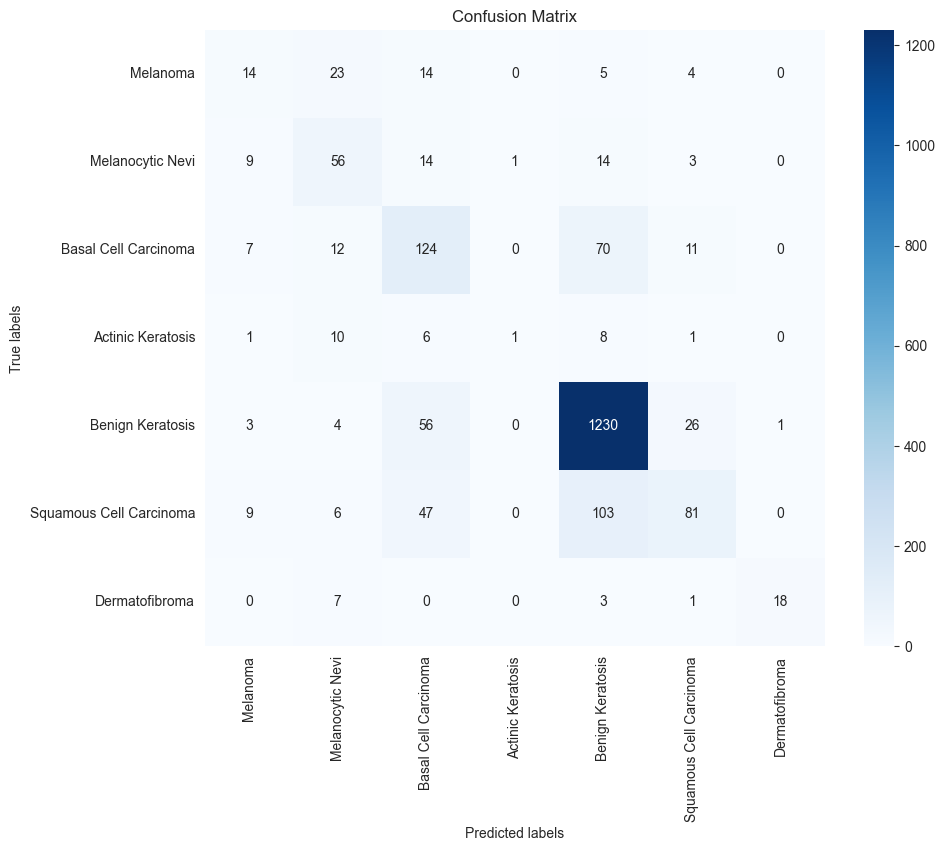

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Evaluate model on test set
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict probabilities for each class
y_pred_probabilities = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotsdfg confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Melanoma', 'Melanocytic Nevi', 'Basal Cell Carcinoma', 
                         'Actinic Keratosis', 'Benign Keratosis', 'Squamous Cell Carcinoma', 
                         'Dermatofibroma'],
            yticklabels=['Melanoma', 'Melanocytic Nevi', 'Basal Cell Carcinoma', 
                         'Actinic Keratosis', 'Benign Keratosis', 'Squamous Cell Carcinoma', 
                         'Dermatofibroma'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.svg', format='svg')  # Save plot as SVG file
plt.show()


In [35]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 1s 36ms/step - loss: 0.6063 - accuracy: 0.7843
Validation: accuracy = 0.784289  ;  loss_v = 0.606305
Test: accuracy = 0.760859  ;  loss = 0.623588


63/63 [==============================] - 2s 37ms/step


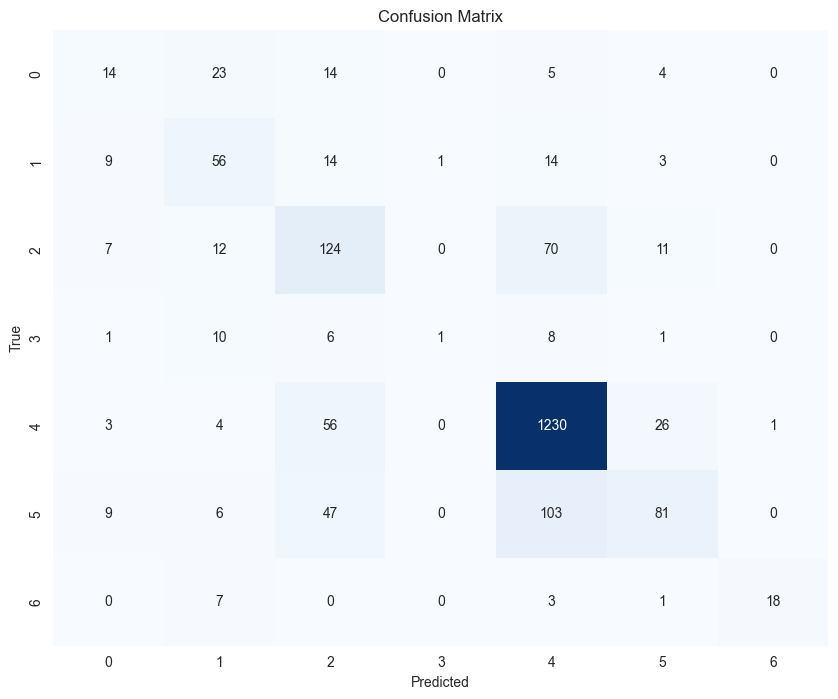

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predicted probabilities for each class
y_pred_probabilities = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Convert one-hot encoded labels back to categorical labels
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('plot.svg', format='svg')
plt.show()


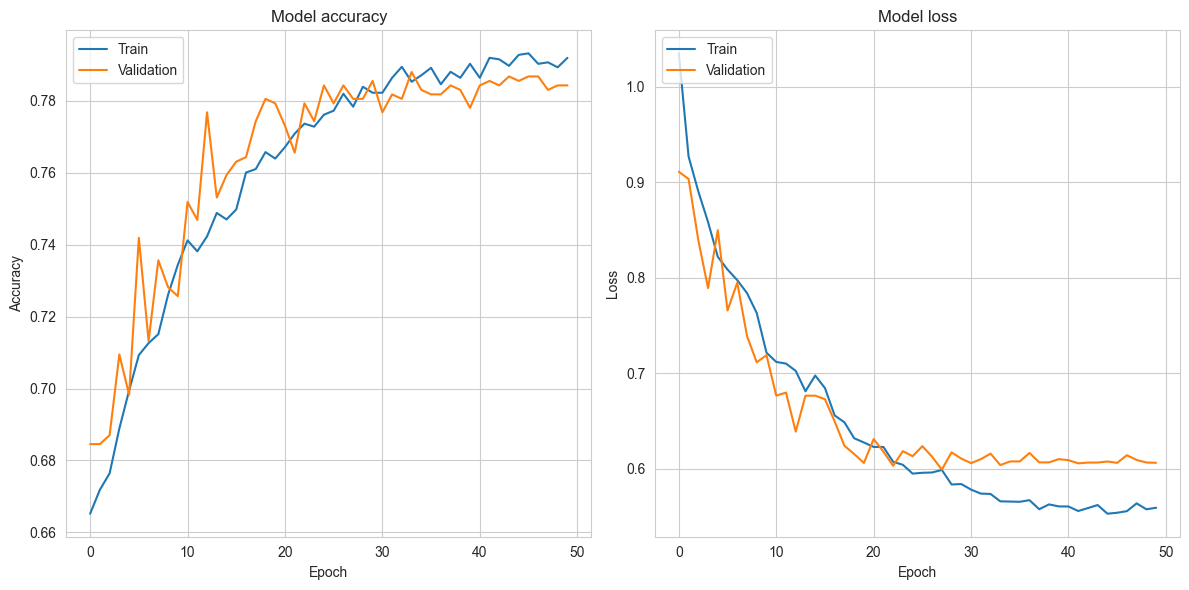

In [37]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Save the plot as SVG
plt.savefig('plot.svg', format='svg')
plt.tight_layout()
plt.show()


In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Accuracy
accuracy = accuracy_score(y_true, y_pred)*100

# Precision
precision = precision_score(y_true, y_pred, average='weighted')*100

# Recall
recall = recall_score(y_true, y_pred, average='weighted')*100

# F1 score
f1 = f1_score(y_true, y_pred, average='weighted')*100

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Accuracy: 76.08587119321018
Precision: 75.03091543556079
Recall: 76.08587119321018
F1 score: 74.4557298372884


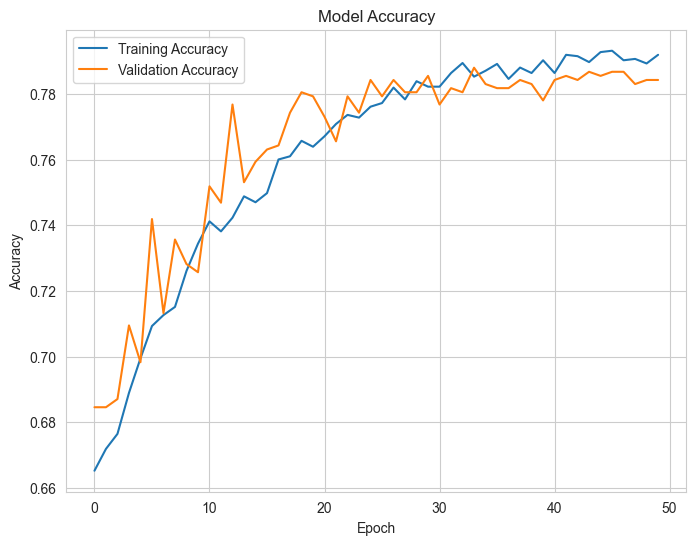

In [39]:
import matplotlib.pyplot as plt

# Plot training accuracy and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.svg', format='svg')
plt.show()

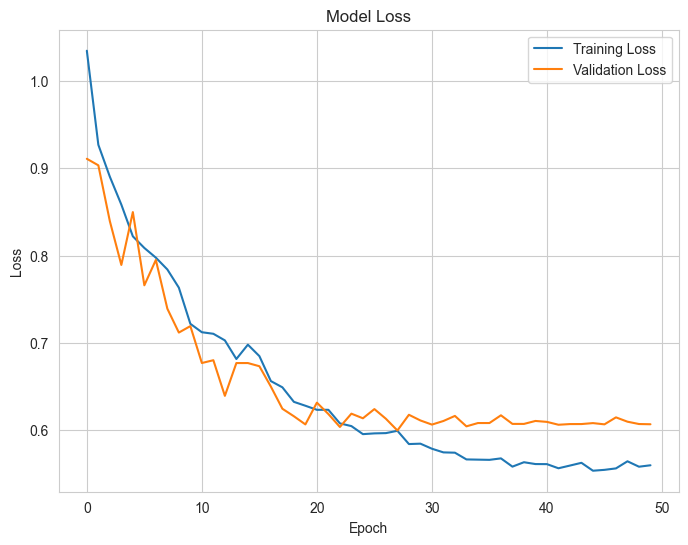

In [40]:
# Plot training loss and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.svg', format='svg')
plt.show()